# Model 3: G/G/2
Based on Lab 5 code

In [109]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [110]:
#Load Data as arrays
RA = pd.read_csv('RANorm.csv', names=['arrival'], usecols=[1])
RD = pd.read_csv('RDNorm.csv', names=['departure'], usecols=[1])
LA = pd.read_csv('LANorm.csv', names=['arrival'], usecols=[1])
LD = pd.read_csv('LDNorm.csv', names=['departure'], usecols=[1])

# Convertime string to seconds
RD["departure"] = pd.to_timedelta(RD["departure"].radd("00:")).dt.total_seconds()
RA["arrival"] = pd.to_timedelta(RA["arrival"].radd("00:")).dt.total_seconds()
LD["departure"] = pd.to_timedelta(LD["departure"].radd("00:")).dt.total_seconds()
LA["arrival"] = pd.to_timedelta(LA["arrival"].radd("00:")).dt.total_seconds()

# Merge into right and left Dataframes
right = pd.concat([RA, RD], axis=1)
left = pd.concat([LA, LD], axis=1)

# add new column "serving time", the difference between departure and the max of arrival or the previous departure
serving_time = []
for i in range(len(right)):
    if i == 0:
        serving_time.append(right['departure'][i] - right['arrival'][i])
    else:
        serving_time.append(right['departure'][i] - max(right['arrival'][i], right['departure'][i-1]))
right['serving_time'] = serving_time
right['serving_time'] = right['serving_time'].clip(lower=0)

serving_time = []
for i in range(len(left)):
    if i == 0:
        serving_time.append(left['departure'][i] - left['arrival'][i])
    else:
        serving_time.append(left['departure'][i] - max(left['arrival'][i], left['departure'][i-1]))
left['serving_time'] = serving_time
left['serving_time'] = left['serving_time'].clip(lower=0)

# add new column "waiting time", which is just the departure time minus the arrival time
right['waiting_time'] = right['departure'] - right['arrival']
right['waiting_time'] = right['waiting_time'].clip(lower=0)

left['waiting_time'] = left['departure'] - left['arrival']
left['waiting_time'] = left['waiting_time'].clip(lower=0)

# get the interarrival time for the system (right + left)
interarrival = []

right['server'] = 'right'
left['server'] = 'left'

combined = pd.concat([right, left], axis=0)
combined = combined.sort_values(by=['arrival'])
combined = combined.reset_index(drop=True)

for i in range(len(combined)):
    if i == 0:
        interarrival.append(combined['arrival'][i])
    else:
        interarrival.append(combined['arrival'][i] - combined['arrival'][i-1])
combined['interarrival'] = interarrival
combined['interarrival'] = combined['interarrival'].clip(lower=0)

In [111]:
W = combined['waiting_time'].mean()
print("Observed average waiting time: ", W)

Observed average waiting time:  25.39282738095238


In [112]:
from SimPy.Simulation import *

In [113]:
class Source(Process):
    """generate random arrivals"""
    def run(self, data):
        for i in range(len(data)):
            row = data.iloc[i]
            a = Arrival(str(i))
            activate(a, a.run(max(row["departure"] - row["arrival"], 0), row["server"]))
            if i < len(data) - 1:
                t = data.iloc[i+1]["arrival"] - row["arrival"]
                yield hold, self, t

In [114]:
class G:
    def __init__(self, c):
        self.server = Resource(capacity=c, monitored=True)
        self.delaymon = Monitor()
        self.numbermon = Monitor()
        self.busymon = Monitor()
        self.paimon = [Monitor() for i in range(100)]
        self.c = c

g = G(1)

In [115]:
class Arrival(Process):
    """an arrival"""
    n = 0  # class variable (number in system)

    def run(self, t, server):
        # Event: arrival
        g.paimon[Arrival.n].observe(0)
        Arrival.n += 1   # number in system
        arrivetime = now()
        g.numbermon.observe(Arrival.n)
        if (Arrival.n>0):
            g.busymon.observe(1)
        else:
            g.busymon.observe(0)

        g.paimon[Arrival.n].observe(1)

        yield hold, self, t

        g.paimon[Arrival.n].observe(0)
        
        Arrival.n -= 1

        g.paimon[Arrival.n].observe(1)
        g.numbermon.observe(Arrival.n)
        if (Arrival.n>0):
            g.busymon.observe(1)
        else:
            g.busymon.observe(0)
        delay = now()-arrivetime
        g.delaymon.observe(delay)

In [116]:
def model(c, N, data, maxtime, rvseed):
    # setup
    initialize()
    random.seed(rvseed)
    
    global g 
    g = G(c)
    
    Arrival.n = 0
   
    # simulate
    s = Source('Source')
    activate(s, s.run(data))
    simulate(until=maxtime)

    # gather performance measures
    W = g.delaymon.mean()
    L = g.numbermon.timeAverage()
    B = g.busymon.timeAverage()
    return W, L, B

In [117]:
W, L, B = model(1, 1, combined, 100000, 12345)
print("Simulated average waiting time: ", W)
print("Simulated average number in system: ", L)
print("Simulated average busy server time: ", B)

Simulated average waiting time:  25.392827380952387
Simulated average number in system:  10.264295080783903
Simulated average busy server time:  0.9124911276060778


In [119]:
for i, mon in enumerate(g.paimon):
    if mon:
        print(i, mon.timeAverage())

0 0.08750887239392229
1 0.0701009347593324
2 0.0529786184408431
3 0.042967479184991456
4 0.02830814507472044
5 0.028056547331853542
6 0.03509090249301455
7 0.04535637149028084
8 0.028898781288768716
9 0.044113350861817426
10 0.03988079908759769
11 0.03170785579306494
12 0.07007089410116799
13 0.02873690423491221
14 0.05942681047765798
15 0.02766328766105995
16 0.06864775701050473
17 0.043583565974479925
18 0.041724258395734175
19 0.04624328216656771
20 0.06524355706598649
21 0.03356513676402454
22 0.19395553496989343
23 0.10339753879079748
24 0.18945042805854598
25 0.07931354359925774
26 0.0017130620985019453


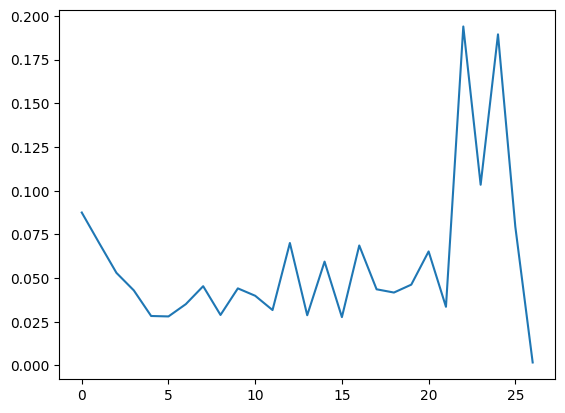

In [120]:
# 0 0.08750887239392229
# 1 0.0701009347593324
# 2 0.0529786184408431
# 3 0.042967479184991456
# 4 0.02830814507472044
# 5 0.028056547331853542
# 6 0.03509090249301455
# 7 0.04535637149028084
# 8 0.028898781288768716
# 9 0.044113350861817426
# 10 0.03988079908759769
# 11 0.03170785579306494
# 12 0.07007089410116799
# 13 0.02873690423491221
# 14 0.05942681047765798
# 15 0.02766328766105995
# 16 0.06864775701050473
# 17 0.043583565974479925
# 18 0.041724258395734175
# 19 0.04624328216656771
# 20 0.06524355706598649
# 21 0.03356513676402454
# 22 0.19395553496989343
# 23 0.10339753879079748
# 24 0.18945042805854598
# 25 0.07931354359925774
# 26 0.0017130620985019453

import matplotlib.pyplot as plt

plt.plot([mon.timeAverage() for mon in g.paimon])
plt.show()